# Spatial integration of the human myocardial infarction

Human myocardial infarction **scRNA-seq**, **scATAC-seq** and **10x Visium** data:<br>https://cellxgene.cziscience.com/collections/8191c283-0816-424b-9b61-c3e1d6258a77<br>   https://zenodo.org/record/6578553 <br>  https://zenodo.org/record/6578617.

## Import

In [23]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import simo
from simo import load_data, process_anndata, find_marker, alignment_1_batch, assign_coord_1, alignment_2, assign_coord_2
from simo.regulation import regulation_analysis, spatial_regulation
from simo import sdplot, sfplot, cor_plot, module_vilolin_plot, module_dot_plot, module_pca_plot, module_spatial_plot, module_heatmap_plot, spatial_lineplot, plot_3d
from simo.helper import extract_reduction
import warnings
warnings.filterwarnings("ignore")

path = '/slurm/home/yrd/fanlab/yangpenghui/SIMO/data/human_heart/RZ_P3'

## Load data

The data pre-processing step is omitted here. Simply put, we retain the low-dimensional embedding representation of single-cell data in the original data and perform preprocessing. The specific code is below
<br> For convenience, we directly loaded the previously stored preprocessed data.

In [6]:
# atac = load_data(path+"/atac.h5ad")
# rna = load_data(path + '/rna.h5ad')
# st = load_data(path+"/spatial.h5ad")
# gam = load_data(path+"/gam.h5ad")

# pos = pd.read_csv(path+"/pos.csv", index_col=0)
# st.obsm['spatial'] = pos.values

# rna.obsm['reduction'] = pd.read_csv(path+"/emb_rna.csv",index_col=0).values
# atac.obsm['reduction'] = pd.read_csv(path+"/emb_atac.csv",index_col=0).values
# gam.obsm['reduction'] = pd.read_csv(path+"/emb_atac.csv",index_col=0).values

# random_cell_indices = rna.obs.sample(n=20000, random_state=42).index
# rna_20k = rna[random_cell_indices, :].copy()

# random_cell_indices = atac.obs.sample(n=20000, random_state=42).index
# atac_20k = atac[random_cell_indices, :].copy()
# gam_20k = gam[random_cell_indices, :].copy()

# ### ST
# st_processed = process_anndata(st,neighbors=True,umap=True,pca=True,n_comps=100)
# sc.tl.leiden(st_processed,resolution=1)
# sc.tl.umap(st_processed)

# ### RNA
# rna_processed = process_anndata(rna_20k,neighbors=False,umap=False,pca=False,n_comps=100)
# sc.pp.neighbors(rna_processed, metric="cosine", use_rep='reduction')
# sc.tl.leiden(rna_processed,resolution=1)
# sc.tl.umap(rna_processed)

# ### ATAC
# atac_processed = atac_20k
# sc.pp.neighbors(atac_processed, metric="cosine", use_rep='reduction')
# sc.tl.leiden(atac_processed,resolution=1)
# sc.tl.umap(atac_processed)

In [8]:
plt.rcParams["figure.figsize"] = (4.5, 4) 

my_col = {
    "Adipocyte": "#218745",
    "Cardiomyocyte": "#273064",
    "Endothelial": "#D42226",
    "Fibroblast": "#862F87",
    "Lymphoid": "#EC7C2D",
    "Mast": "#FFE100",
    "Myeloid": "#819FCC",
    "Neuronal": "#C06BA8",
    "Pericyte": "#D5A564",
    "Cycling cells": "#8FD3E0",
    "vSMCs": "#87C160"
}
cluster_numbers = [str(i) for i in range(23)] 

custom_colors = ['#FF5733', '#33FF57', '#3357FF', '#FFFF33', '#FF33FF', '#33FFFF', 
                 '#FF8533', '#8533FF', '#33FF85', '#3385FF', '#85FF33', '#FF3385', 
                 '#33FF33', '#3333FF', '#FF3333', '#FF8533', '#8533FF', '#FF8585', 
                 '#33FF85', '#3333FF', '#FF33FF', '#33FFFF', '#FFFF33']

desaturated_colors = [sns.desaturate(color, 0.6) for color in custom_colors]
atac_leiden_col = dict(zip(cluster_numbers, desaturated_colors))


cluster_numbers = [str(i) for i in range(20)] 
tab20_colors = sns.color_palette("tab20", n_colors=20)
rna_leiden_col = dict(zip(cluster_numbers, tab20_colors))


In [ ]:
rna_processed = load_data(path + '/rna_processed.h5ad')
gam_processed = load_data(path + '/gam_processed.h5ad')
atac_processed = load_data(path + '/atac_processed.h5ad')
st_processed = load_data(path+"/st_processed.h5ad")

In [ ]:
rna_processed.uns['log1p']["base"] = None
gam_processed.uns['log1p']["base"] = None
st_processed.uns['log1p']["base"] = None

## Alignment of and location adjustment of modality 1 (RNA)

In [4]:
st_processed.obs['cell_type']=st_processed.obs['cell_type'].astype('str')

gene_list1_params = {
    "gene_selection_method": 'deg',
    "deg_num": 100,
    "marker1_by": 'cell_type',
    "marker2_by": 'leiden'
}
gene_list1 = find_marker(st_processed,
                         rna_processed, 
                         **gene_list1_params)

alignment_1_params = {
    "alpha": 0.1,
    "G_init": None,
    "p_distribution": None,
    "q_distribution": None,
    "aware_st_label": "cell_type",
    "aware_sc_label": "leiden",
    "batch_size": 2
}
out1 = alignment_1_batch(adata1=st_processed[:, gene_list1],
                   adata2=rna_processed[:, gene_list1],
                   **alignment_1_params)


assign_coord_1_params = {
    "non_zero_probabilities": True,
    "no_repeated_cells": True,
    "top_num": 3,
    "expected_num": None,
    "pos_random": False,
    "layer": 'data'
}

st_processed.obs['type']=st_processed.obs['cell_type']
rna_processed.obs['type']=rna_processed.obs['leiden']

map1 = assign_coord_1(adata1=st_processed[:, gene_list1], 
                      adata2=rna_processed[:, gene_list1], 
                      out_data=out1,
                      **assign_coord_1_params)

rna_mapped = rna_processed[map1.cell]
rna_mapped.obsm['spatial'] = map1[['Cell_xcoord','Cell_ycoord']].values
rna_mapped.obs['spot'] = map1['spot'].tolist()
rna_mapped.obs['spot_type'] = map1['spot_type'].tolist()

Number of common genes: 15433
Splitting dataset into 2 subsets...
Running alignment on subset 1/2...
Calculating dissimilarity using euclidean distance on scaled data...
Processing RNA data...
Identifying highly variable genes...
Normalizing total counts...
Applying log1p transformation...
Saving pre-log1p counts to a layer...
Scaling the data...
Processing completed.
Constructing connectivity...
k = 10
aware_st = True
aware power = 2
aware_sc = True
aware power = 2
Running OT...
alpha = 0.1
OT done!
Running alignment on subset 2/2...
Calculating dissimilarity using euclidean distance on scaled data...
Processing RNA data...
Identifying highly variable genes...
Normalizing total counts...
Applying log1p transformation...
Saving pre-log1p counts to a layer...
Scaling the data...
Processing completed.
Constructing connectivity...
k = 10
aware_st = True
aware power = 2
aware_sc = True
aware power = 2
Running OT...
alpha = 0.1
OT done!
Assigning spatial coordinates to cells...
random = Fal

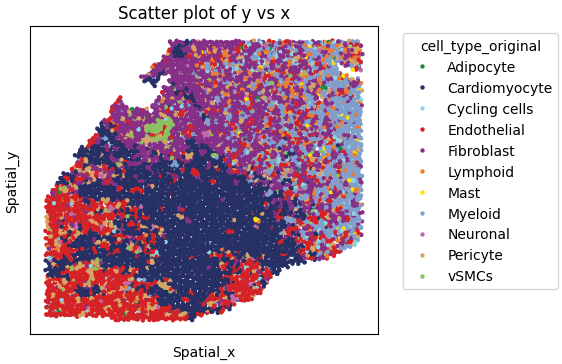

In [7]:
sdplot(rna_mapped,color_col='cell_type_original',size=10,palette=my_col,rotation_angle=0)

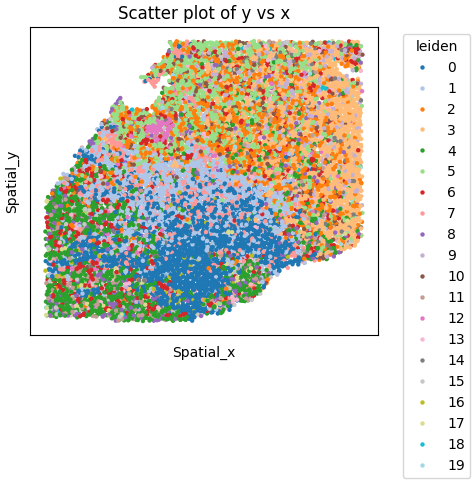

In [8]:
sdplot(rna_mapped,color_col='leiden',palette=rna_leiden_col,size=10,rotation_angle=0)

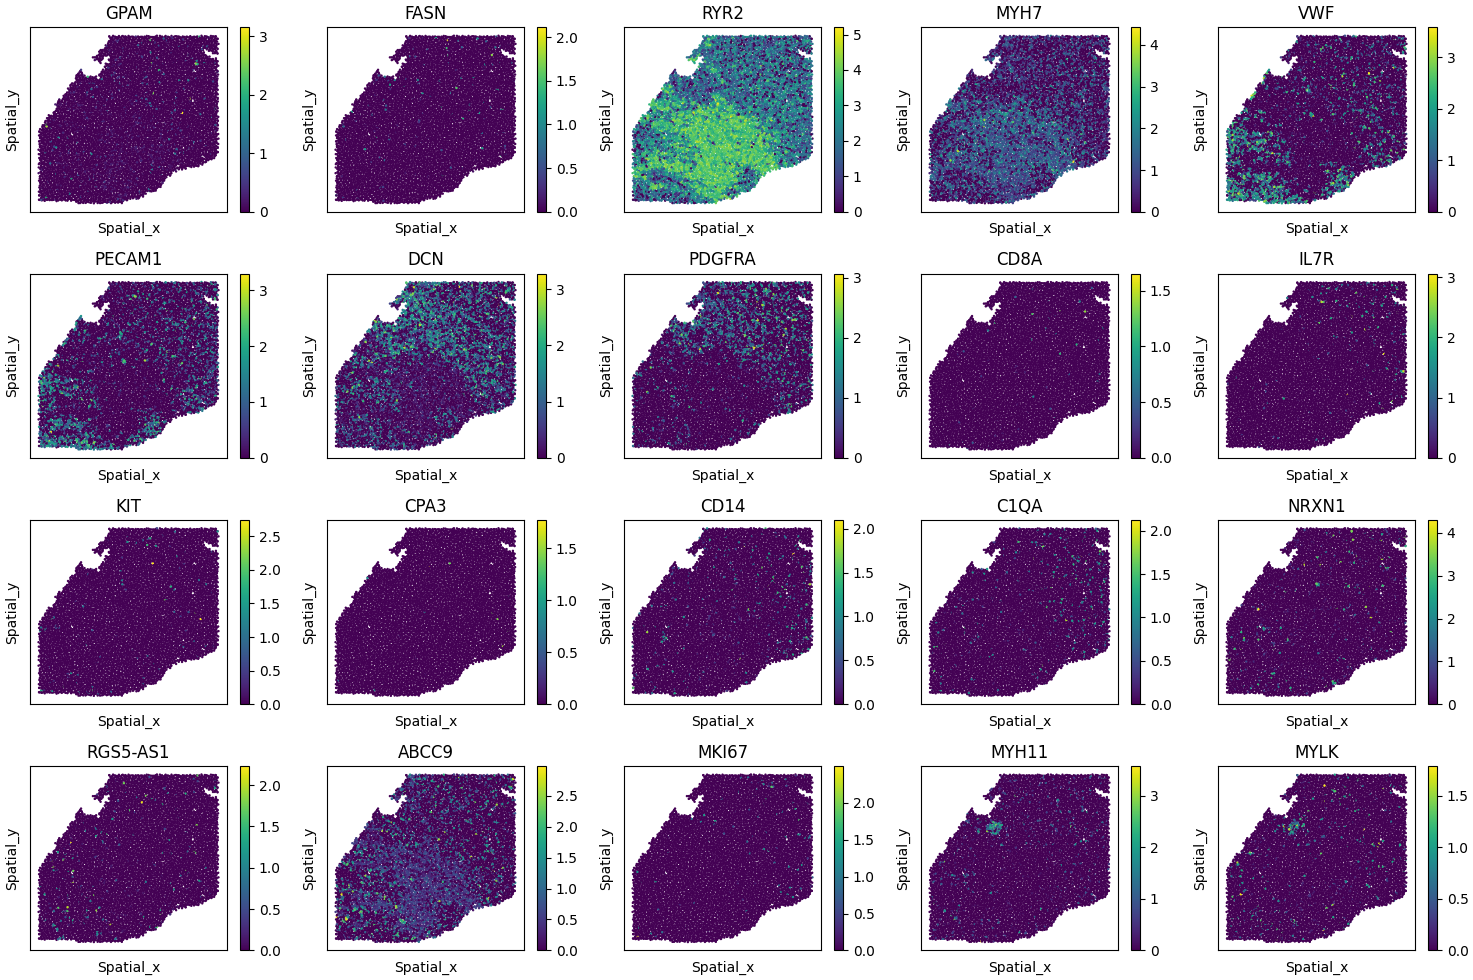

In [9]:
genes_list = [
    "GPAM", "FASN", "RYR2", "MYH7", "VWF", "PECAM1", "DCN", "PDGFRA",
    "CD8A", "IL7R", "KIT", "CPA3", "CD14", "C1QA", "NRXN1", "RGS5-AS1",
    "ABCC9", "MKI67", "MYH11", "MYLK"
]
sfplot(rna_mapped,features=genes_list,size=3,rotation_angle=0,figsize=(15,10))

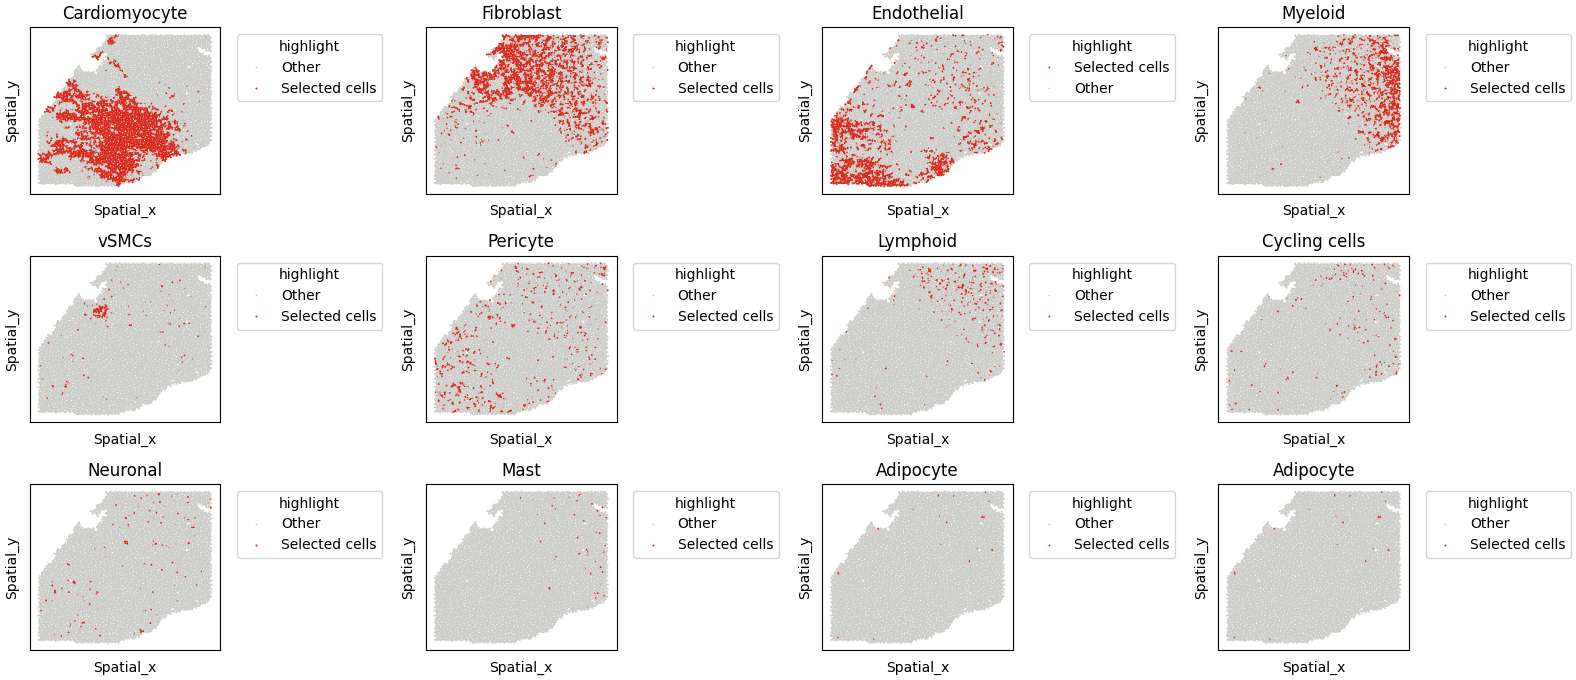

In [10]:
highlight_list = ['Cardiomyocyte','Fibroblast', 'Endothelial', 'Myeloid','vSMCs','Pericyte','Lymphoid','Cycling cells','Neuronal','Mast','Adipocyte','Adipocyte']
sdplot(rna_mapped,
           color_col='cell_type_original',
           highlight=highlight_list,
           size=2,
           ncols=4,
           marker='o',
           rotation_angle=0,
           show_ticks=False,
           x_label='Spatial_x',
           y_label='Spatial_y',
           palette='Set1',
           show=True,
           set_equal=False,figsize=(16,7))

In [11]:
## Alignment of and location adjustment of modality 2 (ATAC)

In [12]:
gene_list2_params = {
    "gene_selection_method": 'deg',
    "marker1_by": "leiden",  
    "marker2_by": "leiden",  
}
gene_list2 = find_marker(rna_mapped, 
                         gam_processed, 
                         **gene_list2_params)

alignment_2_params = {
    "reg": 1,
    "cutoff": 0,
    "layer": None,
    "transfer_obs1": None,
    "transfer_obs2": None,
    "adata1_avg_by": 'leiden',
    "adata2_avg_by": 'leiden',
    "modality2_type": 'pos',
    "reverse": False
}

out2,transfer_df,obs_df1,obs_df2 = alignment_2(adata1=rna_mapped[:, gene_list2].copy(), 
                                               adata2=gam_processed[:, gene_list2].copy(), 
                                               coor_df=map1,
                                               **alignment_2_params)

rna_mapped.obs['annotation'] = obs_df1['annotation']
atac_processed.obs['annotation'] = obs_df2['annotation']
gam_processed.obs['annotation'] = obs_df2['annotation']

assign_coord_2_params = {
    "non_zero_probabilities": True,
    "no_repeated_cells": True,
    "top_num": 3,
    "pos_random": False
}
st_processed.obs['type']=st_processed.obs['cell_type']
atac_processed.obs['type']=atac_processed.obs['cell_type']
map2 = assign_coord_2(adata1=st_processed, 
                      adata2=atac_processed, 
                      out_data=out2,
                      **assign_coord_2_params)

atac_mapped = atac_processed[map2.cell.tolist()]
atac_mapped.obsm['spatial'] = map2[['Cell_xcoord','Cell_ycoord']].values
atac_mapped.obs['spot'] = map2['spot'].tolist()
atac_mapped.obs['spot_type'] = map2['spot_type'].tolist()

gam_mapped = gam_processed[map2.cell.tolist()]
gam_mapped.obsm['spatial'] = map2[['Cell_xcoord','Cell_ycoord']].values
gam_mapped.obs['spot'] = map2['spot'].tolist()
gam_mapped.obs['spot_type'] = map2['spot_type'].tolist()

Number of common genes: 18991
Performing label transfer...
Calculating average expression...
Computing correlation matrix...
Performing unbalanced optimal transport...
Applying cutoff to transfer probabilities and mapping labels...
Label transfer completed.
Processing cell type 1/18: 10
Processing cell type 2/18: 4
Processing cell type 3/18: 6
Processing cell type 4/18: 13
Processing cell type 5/18: 15
Processing cell type 6/18: 2
Processing cell type 7/18: 20
Processing cell type 8/18: 7
Processing cell type 9/18: 3
Processing cell type 10/18: 1
Processing cell type 11/18: 12
Processing cell type 12/18: 17
Processing cell type 13/18: 11
Processing cell type 14/18: 21
Processing cell type 15/18: 19
Processing cell type 16/18: 14
Processing cell type 17/18: 16
Processing cell type 18/18: 22
Assigning spatial coordinates to cells...
random = False
Maximum number of cells assigned to spots: 3
There are 3771 spots and 3471 of them were assigned cells.
Assignment done!


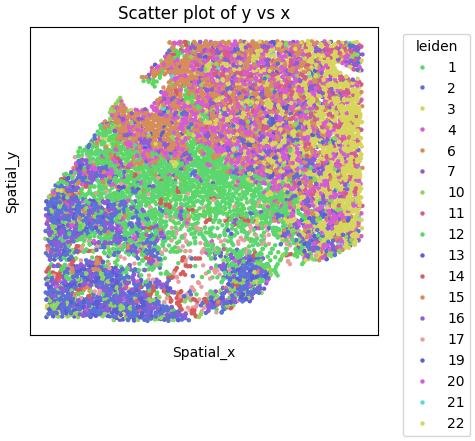

In [13]:
sdplot(atac_mapped,color_col='leiden',palette=atac_leiden_col,size=10,rotation_angle=0)

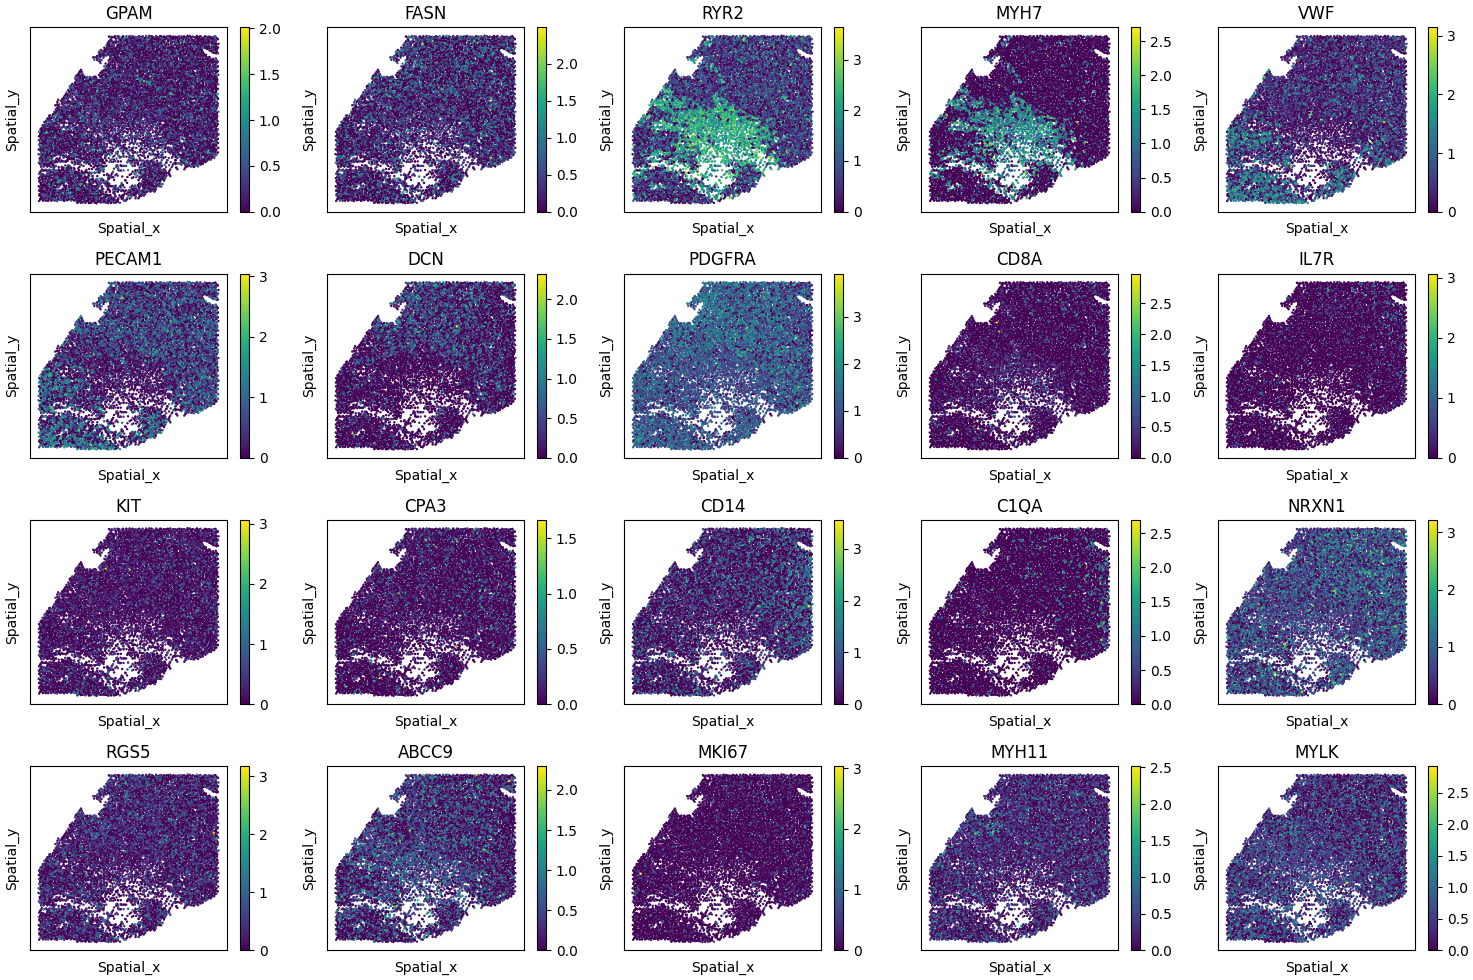

In [14]:
genes_list = [
    "GPAM", "FASN", "RYR2", "MYH7", "VWF", "PECAM1", "DCN", "PDGFRA",
    "CD8A", "IL7R", "KIT", "CPA3", "CD14", "C1QA", "NRXN1", "RGS5",
    "ABCC9", "MKI67", "MYH11", "MYLK"
]
sfplot(gam_mapped,features=genes_list,size=3,rotation_angle=0,figsize=(15,10))

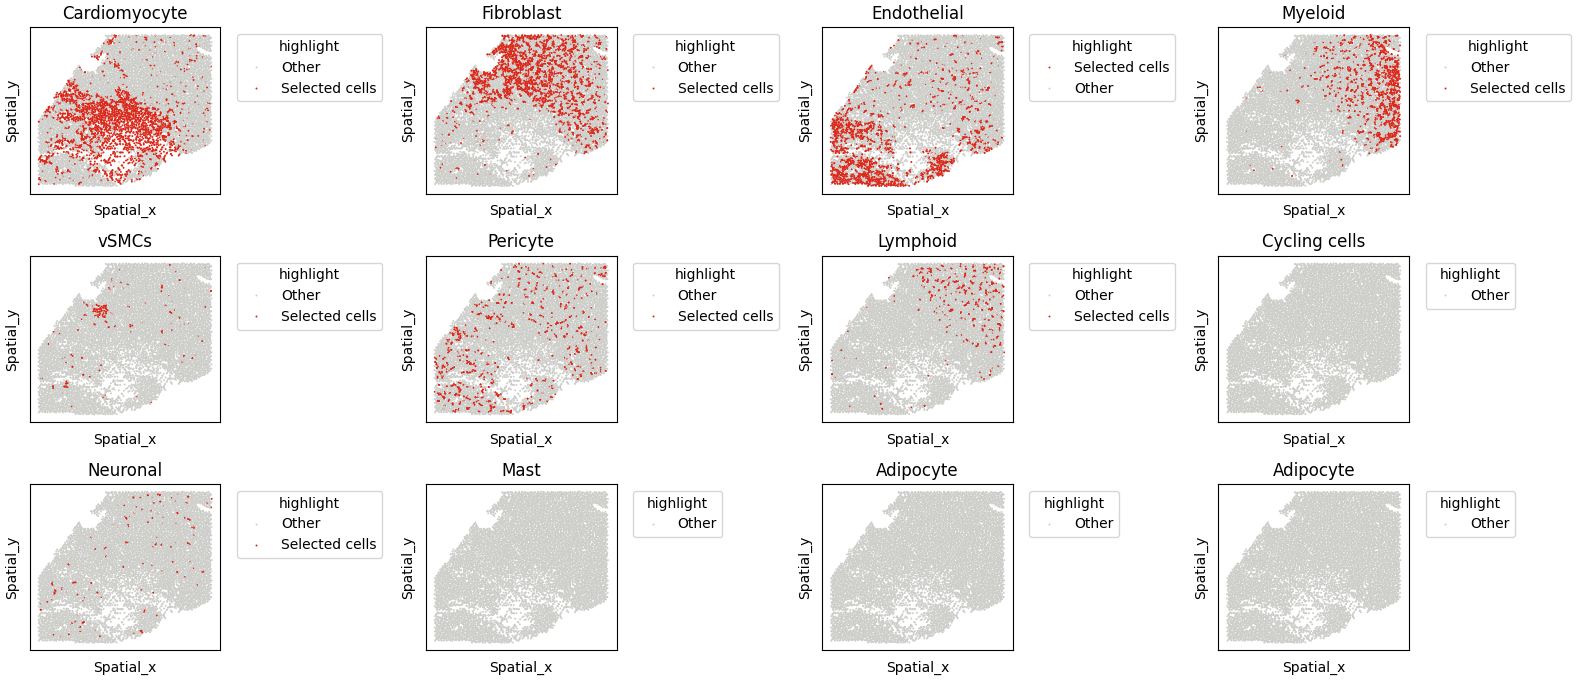

In [15]:
highlight_list = ['Cardiomyocyte','Fibroblast', 'Endothelial', 'Myeloid','vSMCs','Pericyte','Lymphoid','Cycling cells','Neuronal','Mast','Adipocyte','Adipocyte']
sdplot(gam_mapped,
           color_col='cell_type_original',
           highlight=highlight_list,
           size=2,
           ncols=4,
           marker='o',
           rotation_angle=0,
           show_ticks=False,
           x_label='Spatial_x',
           y_label='Spatial_y',
           palette='Set1',
           show=True,
           set_equal=False,figsize=(16,7))

## Regulation analysis
Motif activity needs to be prepared separately. Here we directly load the processed data. The data is calculated through Signac and converted into anndata form

In [4]:
chromvar = load_data("/slurm/home/yrd/fanlab/yangpenghui/SIMO/data/human_heart/RZ_P3/chromvar/chromvar.h5ad")
chromvar_mapped = chromvar[gam_mapped.obs.index]
chromvar_mapped.obs = gam_mapped.obs
chromvar_mapped.obsm = gam_mapped.obsm
chromvar_mapped.layers['data'] = chromvar_mapped.X

The feature_transfer_df data frame stores the correspondence between gene-motifs

In [5]:
feature_transfer_df = pd.read_csv('/slurm/home/yrd/fanlab/yangpenghui/SIMO/data/human_heart/RZ_P3/chromvar/feature_transfer_df.csv',index_col=0)

In [6]:
final_result = regulation_analysis(rna_mapped, 
                                   chromvar_mapped, 
                                   marker1_by='cell_type_original',
                                   marker2_by='cell_type_original',
                                   layer1='data',
                                   layer2='data',
                                   method='wilcoxon',
                                   feature_transfer_df=feature_transfer_df, 
                                   deg_pval_threshold=0.05,log=False)
# met_order = [
#     "mL2/3", "mL4", "mL5-1", "mDL-1", "mDL-2", "mL5-2",
#     "mL6-1", "mL6-2", "mDL-3", "mIn-1", "mVip",
#     "mNdnf-1", "mNdnf-2", "mPv", "mSst-1", "mSst-2"
# ]
# final_result['group'] = pd.Categorical(final_result['group'], categories=met_order)

sig_df = final_result[final_result['pearson_pvalue'] < 0.05]
sig_df['mode'] = sig_df['pearson_correlation'].apply(lambda x: 'pos' if x > 0 else 'neg')
neg_df = final_result[(final_result['pearson_pvalue'] < 0.05) & (final_result['pearson_correlation'] < 0)]
pos_df = final_result[(final_result['pearson_pvalue'] < 0.05) & (final_result['pearson_correlation'] > 0)]

Processing: 100%|██████████| 369/369 [00:03<00:00, 97.72it/s] 


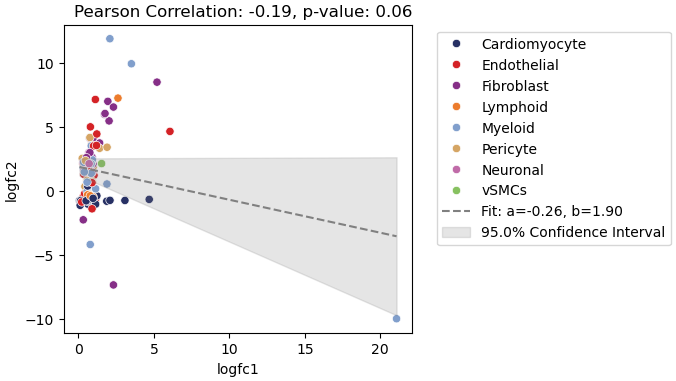

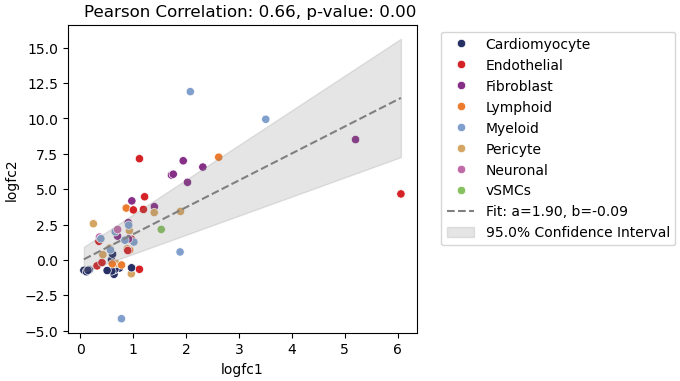

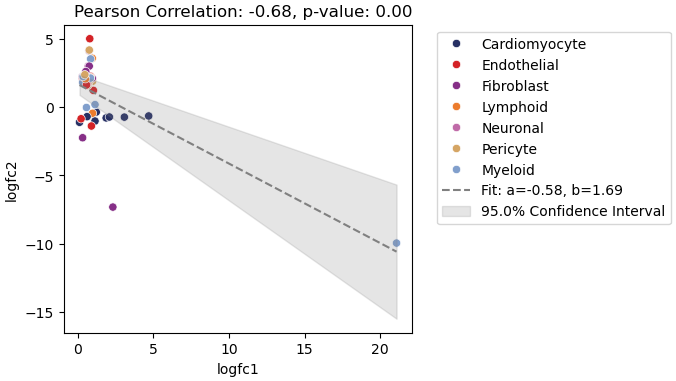

In [9]:
cor_plot(sig_df['logfc1'], sig_df['logfc2'], sig_df['group'], fit_color='grey',palette=my_col, fit_linestyle='--',figsize=(4.5, 4),show=True)
cor_plot(pos_df['logfc1'], pos_df['logfc2'], pos_df['group'], fit_color='grey',palette=my_col, fit_linestyle='--',figsize=(4.5, 4),show=True)
cor_plot(neg_df['logfc1'], neg_df['logfc2'], neg_df['group'], fit_color='grey',palette=my_col, fit_linestyle='--',figsize=(4.5, 4),show=True)

## Spatial regulation analysis (Cardiomyocytes)

In [11]:
selected_ct = ['Cardiomyocyte']
selected_cluster = ['0','1','7']

rna_mapped_cm = rna_mapped[rna_mapped.obs['cell_type_original'].isin(selected_ct)&
                          rna_mapped.obs['leiden'].isin(selected_cluster)]
chromvar_mapped_cm = chromvar_mapped[chromvar_mapped.obs['spot'].isin(rna_mapped_cm.obs['spot'])&
                                    chromvar_mapped.obs['cell_type_original'].isin(selected_ct)]

np.random.seed(1234)
cm_sr =  spatial_regulation(rna_mapped_cm, 
                           chromvar_mapped_cm,
                           regulation_df=None,
                           feature_transfer_df=feature_transfer_df, 
                           layer1='data',
                           layer2='data',
                           smooth_k=10,
                           sigma=140, 
                           correlation='pearson',
                           epsilon=1e-3,
                           minK=2,
                           maxK=8,
                           rep=20,
                           resample_proportion=0.5,
                           cc_k=8,
                           avg_con_min=0.5,
                           avg_cor_min=0.5,
                           min_feature=20,
                           max_feature=200
                          )
cm_sr['cc'].module = (cm_sr['cc'].module.astype(int) + 1).astype(str)

Starting spatial regulation analysis...
Processing spatial regulation...


Processing: 100%|██████████| 599/599 [00:00<00:00, 2658.14it/s]


Clustering feautres...
Filtering feautres...
0  
1  


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 21.344444444444445 mm


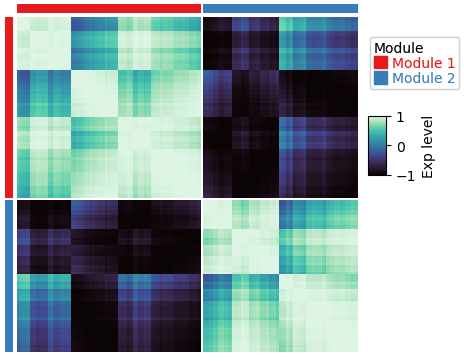

In [12]:
module_heatmap_plot(cm_sr,module_name=["1","2"],show=True,figsize=(4.6,4))

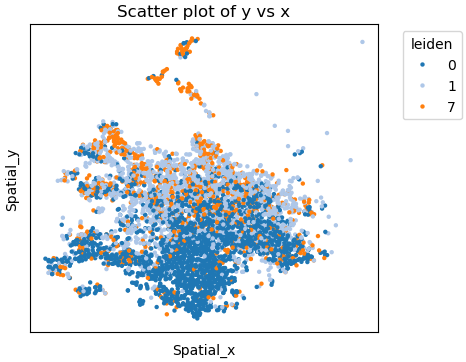

In [13]:
sdplot(rna_mapped_cm,color_col='leiden',size=10,palette='tab20',rotation_angle=0)

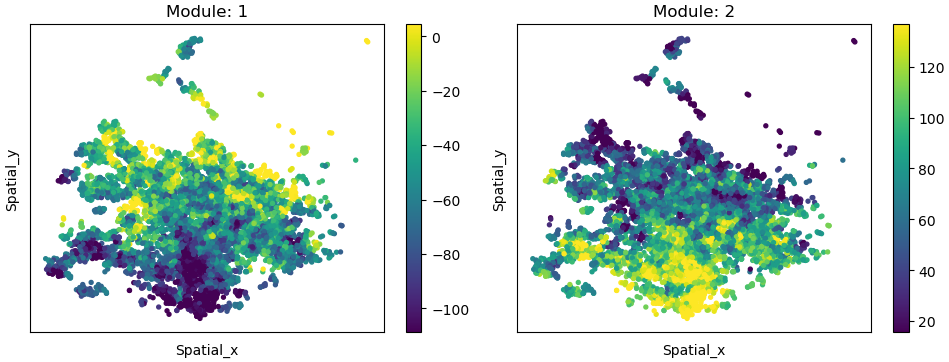

In [14]:
cm_ann = ad.AnnData(X=cm_sr['reg_df'])
cm_ann.obsm['spatial'] = cm_sr['pos']

cm_module = module_spatial_plot(cm_ann,
                    cm_sr,
                    module_name=["1","2"],
                    feature_name="combos",
                    use_raw=False,
                    figsize=(6,4),size=8,rotation_angle=0,return_data=True,
                           min_cutoff=['q5','q5'],max_cutoff=['q95','q95'],show=True)

Combining the results of regulatory analysis and spatial module analysis, users can view the status of transcription factors with significant regulatory effects in the spatial module, including correlations and their adjusted p-values

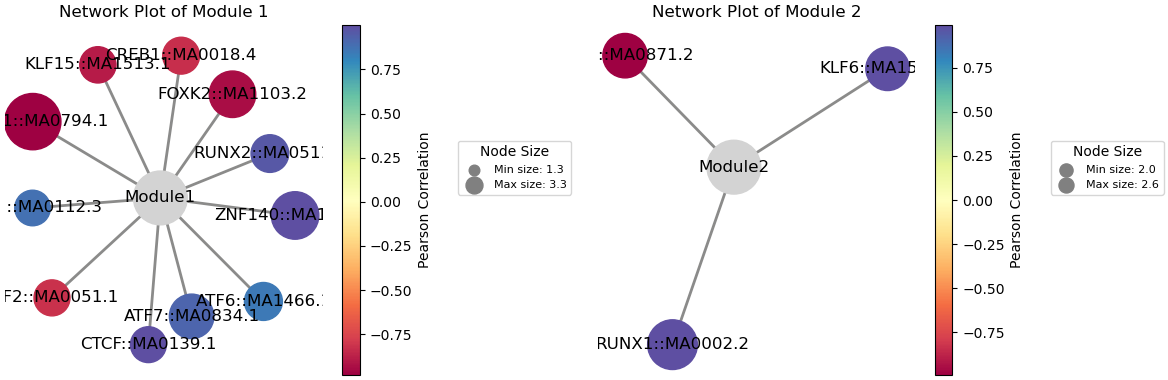

In [17]:
tmp = pd.merge(final_result, cm_sr['cc'], on='combos', how='inner')
tmp = tmp[tmp['pearson_pvalue'] < 0.05]
tmp = tmp.drop_duplicates(subset='combos')
module_names = ['1', '2'] 
plot_network_graph(tmp, module_names=['1', '2'],cmap='Spectral')

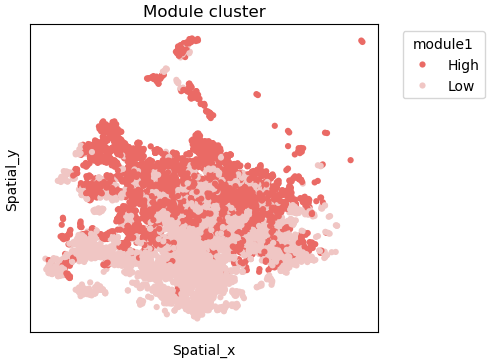

In [19]:
cm_module['score'] = cm_module['score_1'] - cm_module['score_2']
cm_ann.obs['score'] = cm_module['score']
median_score = cm_ann.obs['score'].median()
cm_ann.obs['module1'] = np.where(cm_ann.obs['score'] > median_score, 'High', 'Low')
sdplot(cm_ann,rotation_angle=0,color_col='module1',palette=['#EA6A65','#F0C6C4'],title='Module cluster',show=True)

Here we calculate the distance between the cardiomyocytes of two different groups and the target cells, and see the correlation between the distance and the module score. <br>
Smooth muscle cell:

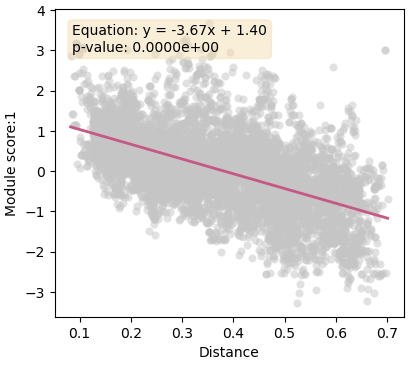

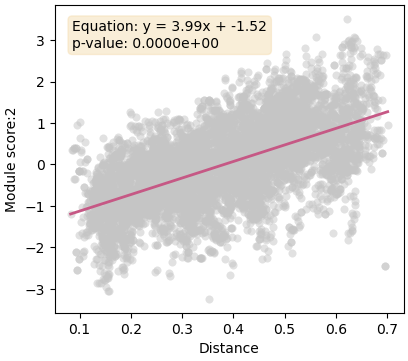

In [24]:
smc = st_processed[(st_processed.obs['cell_type_original']=='vSMCs')&
                  (st_processed.obsm['spatial'][:,1]>0.5)]
root_df = extract_reduction(smc,use_rep='spatial',column_names=['x','y'])
spatial_lineplot(cm_ann,cm_module,score_name='score_1',root_df=root_df,xlabel='Distance',ylabel='Module score:1')
spatial_lineplot(cm_ann,cm_module,score_name='score_2',root_df=root_df,xlabel='Distance',ylabel='Module score:2')

Myeloid cell:

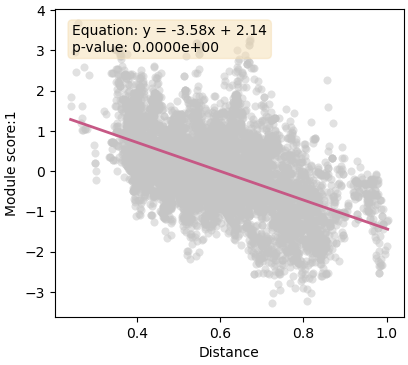

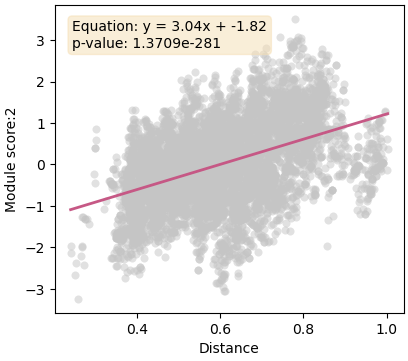

In [25]:
my = st_processed[(st_processed.obs['cell_type_original']=='Myeloid')&
                  (st_processed.obsm['spatial'][:,1]>0.5)]
root_df = extract_reduction(my,use_rep='spatial',column_names=['x','y'])
spatial_lineplot(cm_ann,cm_module,score_name='score_1',root_df=root_df,xlabel='Distance',ylabel='Module score:1')
spatial_lineplot(cm_ann,cm_module,score_name='score_2',root_df=root_df,xlabel='Distance',ylabel='Module score:2')

## Spatial regulation analysis (Fibroblast)
We selected a subset of fibroblasts for analysis

In [27]:
selected_ct = ['Fibroblast']
rna_mapped_fib = rna_mapped[rna_mapped.obs['cell_type_original'].isin(selected_ct)]
chromvar_mapped_fib = chromvar_mapped[chromvar_mapped.obs['cell_type_original'].isin(selected_ct)]
rna_mapped_fib = rna_mapped_fib[rna_mapped_fib.obsm['spatial'][:,1]>0.5]
chromvar_mapped_fib = chromvar_mapped_fib[chromvar_mapped_fib.obsm['spatial'][:,1]>0.5]

np.random.seed(1234)
fib_sr =  spatial_regulation(rna_mapped_fib, 
                           chromvar_mapped_fib,
                           regulation_df=None,
                           feature_transfer_df=feature_transfer_df, 
                           layer1='data',
                           layer2='data',
                           smooth_k=10,
                           sigma=140, 
                           correlation='pearson',
                           epsilon=1e-3,
                           minK=2,
                           maxK=8,
                           rep=20,
                           resample_proportion=0.5,
                           cc_k=8,
                           avg_con_min=0.6,
                           avg_cor_min=0.6,
                           min_feature=20,
                           max_feature=200
                          )
fib_sr['cc'].module = (fib_sr['cc'].module.astype(int) + 1).astype(str)

Starting spatial regulation analysis...
Processing spatial regulation...


Processing: 100%|██████████| 599/599 [00:00<00:00, 2041.31it/s]


Clustering feautres...
Filtering feautres...
0  
1  


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 21.344444444444445 mm


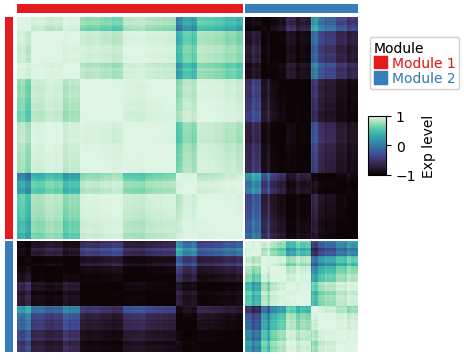

In [28]:
module_heatmap_plot(fib_sr,module_name=["1","2"],figsize=(4.6,4),show=True)

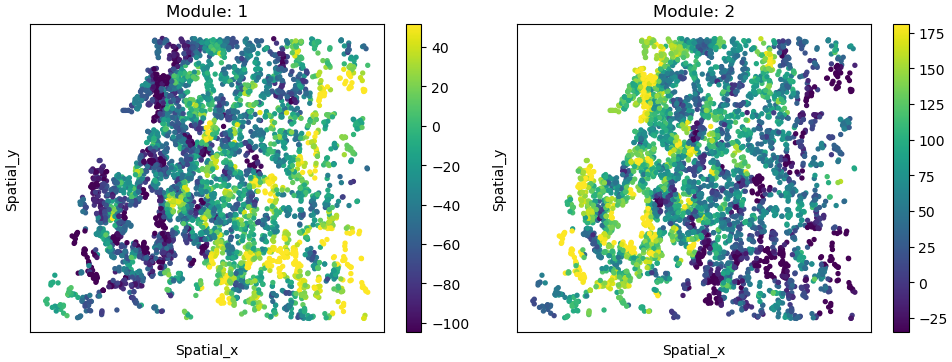

In [29]:
fib_ann = ad.AnnData(X=fib_sr['reg_df'])
fib_ann.obsm['spatial'] = fib_sr['pos']

fib_module = module_spatial_plot(fib_ann,
                    fib_sr,
                    module_name=["1","2"],
                    feature_name="combos",
                    use_raw=False,
                    figsize=(6,4),size=8,rotation_angle=0,return_data=True,
                           min_cutoff=['q5','q5'],max_cutoff=['q95','q95'],show=True)

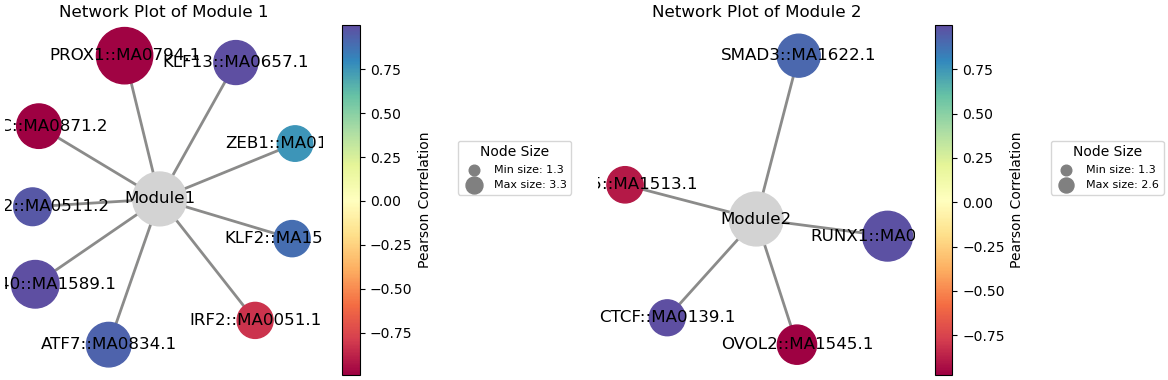

In [30]:
tmp = pd.merge(final_result, fib_sr['cc'], on='combos', how='inner')
tmp = tmp[tmp['pearson_pvalue'] < 0.05]
tmp = tmp.drop_duplicates(subset='combos')
module_names = ['1', '2']  
plot_network_graph(tmp, module_names=['1', '2'],cmap='Spectral')

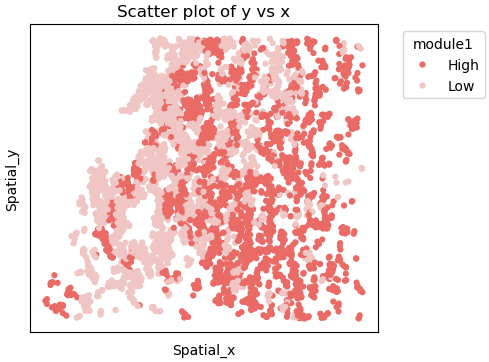

In [31]:
fib_module['score'] = fib_module['score_1'] - fib_module['score_2']
fib_ann.obs['score'] = fib_module['score']
median_score = fib_ann.obs['score'].median()
fib_ann.obs['module1'] = np.where(fib_ann.obs['score'] > median_score, 'High', 'Low')
sdplot(fib_ann,rotation_angle=0,color_col='module1',palette=['#EA6A65','#F0C6C4'],show=True)

Different from the method in cardiomyocytes, since there are clear adjacent cell groups on the left (smooth muscle cell) and right (myeloid cell) sides of cardiomyocytes, here we directly check the correlation between module score and x coordinate

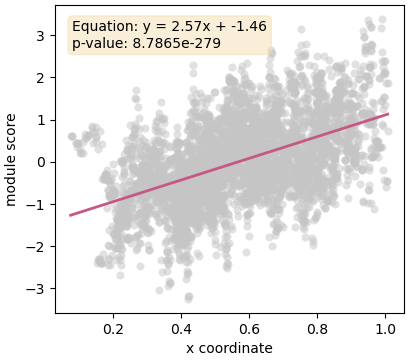

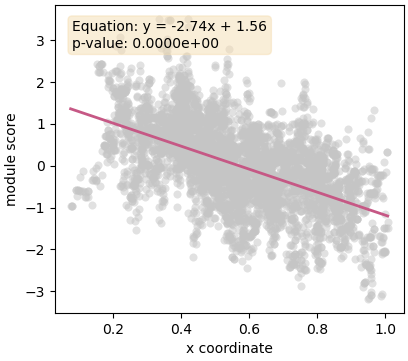

In [32]:
spatial_lineplot(fib_ann,fib_module,score_name='score_1',coord='x')
spatial_lineplot(fib_ann,fib_module,score_name='score_2',coord='x')

## 3D plot

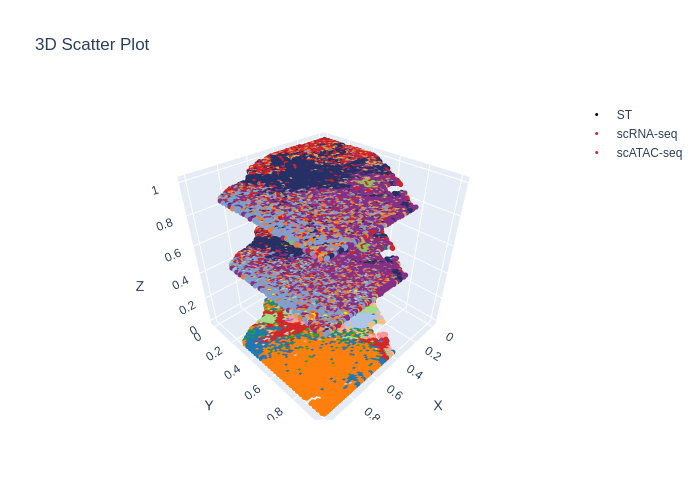

In [34]:
my_col = {
    "Adipocyte": "#218745",
    "Cardiomyocyte": "#273064",
    "Endothelial": "#D42226",
    "Fibroblast": "#862F87",
    "Lymphoid": "#EC7C2D",
    "Mast": "#FFE100",
    "Myeloid": "#819FCC",
    "Neuronal": "#C06BA8",
    "Pericyte": "#D5A564",
    "Cycling cells": "#8FD3E0",
    "vSMCs": "#87C160"
}

leiden_unique = st_processed.obs['leiden'].unique().tolist()
st_colors = plt.get_cmap('tab20').colors
st_col = {label: color for label, color in zip(leiden_unique, st_colors)}

plot_3d(anndatas = [st_processed,rna_mapped,gam_mapped],
                      color_cols = ['leiden','cell_type_original','cell_type_original'],
                      titles = ['ST','scRNA-seq','scATAC-seq'],
                       color_palettes=[st_col,my_col,my_col],sizes=[3, 3, 3], zs=[0, 0.6, 1],
                      save_path='human_heart.html')
